In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
## Read cleaned datasets
df_adult = pd.read_csv('datasets/cleaned/adult_cleaned.csv')
df_occupancy = pd.read_csv('datasets/cleaned/occupancy_cleaned.csv')
df_HTRU2 = pd.read_csv('datasets/cleaned/HTRU2_cleaned.csv')
df_activity = pd.read_csv('datasets/cleaned/activity_cleaned.csv')
dfs = [df_adult, df_occupancy, df_HTRU2, df_activity]

In [24]:
print(df_adult.shape)
print(df_occupancy.shape)
print(df_HTRU2.shape)
print(df_activity.shape)

(32560, 106)
(20560, 6)
(17897, 9)
(52482, 11)


In [25]:
print(df_adult.iloc[:, -1].value_counts())
print(df_occupancy.iloc[:, -1].value_counts())
print(df_HTRU2.iloc[:, -1].value_counts())
print(df_activity.iloc[:, -1].value_counts())

0.0    24719
1.0     7841
Name: salary_>50K, dtype: int64
0.0    15810
1.0     4750
Name: Occupancy, dtype: int64
0.0    16258
1.0     1639
Name: is_pulsar, dtype: int64
0.0    50526
1.0     1956
Name: is_ambulating, dtype: int64


In [26]:
print(df_adult.iloc[:, -1].value_counts()[1] / sum(df_adult.iloc[:, -1].value_counts()))
print(df_occupancy.iloc[:, -1].value_counts()[1] / sum(df_occupancy.iloc[:, -1].value_counts()))
print(df_HTRU2.iloc[:, -1].value_counts()[1] / sum(df_HTRU2.iloc[:, -1].value_counts()))
print(df_activity.iloc[:, -1].value_counts()[1] / sum(df_activity.iloc[:, -1].value_counts()))

0.24081695331695332
0.23103112840466927
0.09157959434542103
0.037269921115811136


C:\Users\Inffzy\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


0.9051441556184129


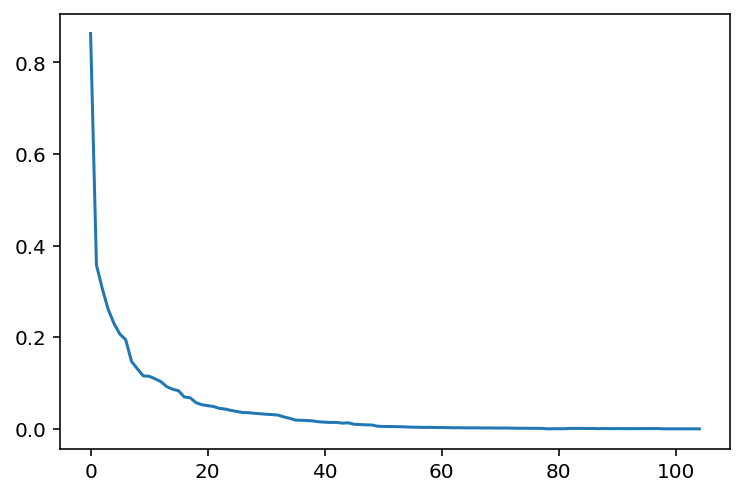

In [4]:
## The Adult dataset contains 105 attributes. Here we seek to reduce its dimensions
## Visualize the Adult dataset's principal components for dimensionality reduction
X = df_adult.iloc[:, :-1]

## Compute covariance matrix of X
X_cov = np.cov(np.transpose(np.array(X)))

## Compute eigen decomposition of covariance matrix of X
eigenvalues, eigenvectors = np.linalg.eig(X_cov)

## Plot the eigenvalues in descending order
plt.plot(eigenvalues)

## From the plot below, we see that the top 30 principal components roughly contains most of the information of
##  the Adult dataset, so we will map the Adult dataset to the subspace spanned by its top 30 principal components.
pca_adult = PCA(n_components=30)
pca_adult.fit(X)

## We print the sum of explained variance ratio and see that the top 30 principal components explains 90% of the
##  variance, which confirms that using the top 30 principal components is a good decision.
print(sum(pca_adult.explained_variance_ratio_))

In [5]:
## Prepare datasets
##   (We do 5 trials for each dataset, resulting in 20 splitted datasets in total)

datasets = []

for i, df in enumerate(dfs):

    ## j is also used as random state control integer
    for j in range(5):
        X = df.iloc[:, :-1]
        Y = df.iloc[:, -1]

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=5000, stratify=Y,
                                                            shuffle=True, random_state=j)
        
        ## We use PCA to reduce the dimension of Adult dataset
        if i == 0:
            X_train = pca_adult.transform(X_train)
            X_test = pca_adult.transform(X_test)

        datasets.append([X_train, X_test, Y_train, Y_test])

In [6]:
## Result storages
num_scores = 2    ## training [0] and testing [1] scores 
num_models = 7    ## 7 variations of models
num_metrics = 3   ## accuracy, f1, roc auc
num_datasets = 20 ## 4 datasets * 5 trials

results_final = np.zeros((num_scores, num_models, num_metrics, num_datasets))
cv_results = []

In [7]:
## Settings

models = [LogisticRegression(), 
          Perceptron(), 
          svm.SVC(),
          svm.SVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier()]

parameter_settings = [{'penalty': ['l2'],               ## Logistic Regression
                             'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                        'solver': ['newton-cg']},
                        
                      {'penalty': ['l1', 'l2'],         ## Perceptron
                         'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
                      
                       {'kernel': ['linear'],           ## SVM Linear
                             'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
                      
                       {'kernel': ['rbf'],              ## SVM RBF
                         'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
                             'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},

                    {'criterion': ['gini', 'entropy'],  ## Decision Tree
                     'max_depth': [10, 50, 100, 500, 1000], 
                     'ccp_alpha': [0, 1e-1, 1e0, 1e1]},
                      
                    {'criterion': ['gini', 'entropy'],  ## Random Forest
                     'ccp_alpha': [0, 1e-1, 1e0, 1e1],
                  'n_estimators': [10, 50, 100, 500, 1000]},
                      
                         {'loss': ['exponential'],      ## Gradient Boosting Classifier
                 'learning_rate': [1e-3, 1e-2, 1e-1, 1e0, 1e1],
                  'n_estimators': [10, 50, 100, 500, 1000]}]

metrics = [accuracy_score, f1_score, roc_auc_score]

In [8]:
for i, dataset in enumerate(datasets):

    X_train = datasets[i][0]
    Y_train = datasets[i][2]
    X_test = datasets[i][1]
    Y_test = datasets[i][3]
    
    for j, model in enumerate(models):
        for k, metric in enumerate(metrics):
        
            ## Make scorer for the current metric
            scorer = make_scorer(metric)
        
            ## Apply grid search with 5-fold cross validation
            classifier = GridSearchCV(model, parameter_settings[j], scoring=scorer, cv=5, verbose=1)
            classifier.fit(X_train, Y_train)
            
            cv_results.append(classifier.cv_results_)
            
            ## Test the best trained parameters  
            print('Best parameters on training data: ', classifier.best_params_)
            
            
            
            result_train = classifier.best_score_
            print('Training result: ', result_train)
            results_final[0, j, k, i] = result_train
        
            Y_pred = classifier.predict(X_test)
            result_test = metric(Y_test, Y_pred)
            print('Testing result: ', result_test)
            
            results_final[1, j, k, i] = result_test

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8298
Testing result:  0.8293541364296081
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.6001144633307822
Testing result:  0.5981692189237745
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7281497278346671
Testing result:  0.7261880451889895
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.1, 'penalty': 'l2'}
Training result:  0.7626
Testing result:  0.6485849056603774
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.4940704959642317
Testing result:  0.6024663987806568
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.6759529804103686
Testing result:  0.7451363725583098
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.5min finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.8246
Testing result:  0.828410740203193
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.5865697711279618
Testing result:  0.5947381952180992
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.7194577913548735
Testing result:  0.724085946021426
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.5min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training result:  0.826
Testing result:  0.8280116110304789
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.5min finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.5967883456119021
Testing result:  0.6005495878091431
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.5min finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.72711777732508
Testing result:  0.7294565209869193
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.792
Testing result:  0.7967706821480406
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.5585979591440724
Testing result:  0.5642823749415615
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.7089481690342663
Testing result:  0.7076113099891563
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.8082


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Testing result:  0.8122278664731495
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.5577392840126147
Testing result:  0.5679768307819612
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 50}
Training result:  0.7038071355857539
Testing result:  0.7112519936582582
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.8273999999999999
Testing result:  0.8281930333817126
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.5963121047084057
Testing result:  0.6011388957662788
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.7276299410351605
Testing result:  0.7304718922783311
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8273999999999999
Testing result:  0.8282656023222061
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5961243998886224
Testing result:  0.6019009168138616
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7258293083277298
Testing result:  0.7295456717104107
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.7772
Testing result:  0.7872641509433962
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.5159626230136578
Testing result:  0.5312011371712865
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.6907906512258374
Testing result:  0.6932039445724172
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.6min finished


Best parameters on training data:  {'C': 0.1, 'kernel': 'linear'}
Training result:  0.8253999999999999
Testing result:  0.8288098693759071
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.6min finished


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.5868212921793938
Testing result:  0.612078606806199
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.6min finished


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.7221709256700046
Testing result:  0.7396201607404826
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.8242
Testing result:  0.8279753265602322
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.5930521154375885
Testing result:  0.6097620799607554
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.7252052371613436
Testing result:  0.7363569382101449
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7948000000000001
Testing result:  0.8025399129172714
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.555441386386925
Testing result:  0.5778224071151915
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.7101868119078304
Testing result:  0.7236857471274581
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.8116
Testing result:  0.8086719883889695
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.5685573418256347
Testing result:  0.5771919954994776
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.2min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.7084481199040933
Testing result:  0.7177015840261664
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.8287999999999999
Testing result:  0.828410740203193
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.590397374099946
Testing result:  0.5938332045005583
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.7213724330383797
Testing result:  0.7234172507845353
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8253999999999999
Testing result:  0.8282656023222061
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5805696256081643
Testing result:  0.6021851444058609
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7155123205238096
Testing result:  0.7292228928025705
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.7741999999999999
Testing result:  0.7713352685050798
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.4941914669294091
Testing result:  0.41203330647327424
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.6714258504123626
Testing result:  0.6200318571973054
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.0min finished


Best parameters on training data:  {'C': 0.01, 'kernel': 'linear'}
Training result:  0.8211999999999999
Testing result:  0.8261248185776487
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.5641751009395886
Testing result:  0.5712583006981099
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.7051886210203481
Testing result:  0.7108341410487298
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training result:  0.8251999999999999
Testing result:  0.8260522496371553
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.5770743430048813
Testing result:  0.5993294216261527
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.7162548630239268
Testing result:  0.7268621485190419
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7942
Testing result:  0.7988751814223513
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.5603456476446298
Testing result:  0.5637456501107244
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.7055528719787102
Testing result:  0.7004833675895109
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.8113999999999999
Testing result:  0.8128084179970972
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 50}
Training result:  0.575308689422512
Testing result:  0.5798874480058722
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.7153490684401292
Testing result:  0.7148393597218082
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.8268000000000001
Testing result:  0.8285195936139332
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 10}
Training result:  0.5871531812963099
Testing result:  0.5736580346424284
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.7204887553046919
Testing result:  0.7223068706021392
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.829
Testing result:  0.829100145137881
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.6010361058252405
Testing result:  0.6047994629971473
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7285827908873095
Testing result:  0.7314326965578481
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.7854000000000001
Testing result:  0.7664005805515239
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.5405956681371554
Testing result:  0.5853298436346553
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.7001882876113413
Testing result:  0.7352664261090179
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 0.1, 'kernel': 'linear'}
Training result:  0.8214
Testing result:  0.8216981132075472
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.5801516038530631
Testing result:  0.5874515095294317
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.7159332812251381
Testing result:  0.720859406349365
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.8252
Testing result:  0.8264513788098694
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.5977767993191307
Testing result:  0.5996192368181442
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.7287680076830096
Testing result:  0.7293236446420188
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7984
Testing result:  0.7992380261248185
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.5693983934770965
Testing result:  0.5474563401670464
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7183058179188315
Testing result:  0.7163587602550606
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.9min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.8138
Testing result:  0.8138969521044993
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.9min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.581587065617495
Testing result:  0.5730346366867819
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 12.9min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 100}
Training result:  0.7179744345426405
Testing result:  0.712452529130053
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.3min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.8273999999999999
Testing result:  0.8295718432510886
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.3min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 10}
Training result:  0.5953552374238211
Testing result:  0.5971403182809597
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.3min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 10}
Training result:  0.7279819964890989
Testing result:  0.7294738002406363
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8324
Testing result:  0.8261611030478955
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.6043877694645664
Testing result:  0.5910611649652568
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7302675828472827
Testing result:  0.721891902068924
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.7777999999999999
Testing result:  0.7918722786647315
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.563450695258102
Testing result:  0.41362478777589134
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.722931709635067
Testing result:  0.626802577400705
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


Best parameters on training data:  {'C': 0.01, 'kernel': 'linear'}
Training result:  0.8311999999999999
Testing result:  0.8257982583454282
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.5868457857296352
Testing result:  0.5644019815994338
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.9min finished


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.7187556902523147
Testing result:  0.7049957948295044
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.8352
Testing result:  0.8271407837445574
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
Training result:  0.5900689705808098
Testing result:  0.5663571818678318
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:  1.4min finished


Best parameters on training data:  {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
Training result:  0.7188438008655542
Testing result:  0.706588431457903
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7966
Testing result:  0.7955007256894049
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.5601924454524649
Testing result:  0.579178776361875
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7060032381315745
Testing result:  0.7238633788638369
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.8123999999999999
Testing result:  0.8124455732946299
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.5785202165861552
Testing result:  0.5721806366702311
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 13.1min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.7206791728492996
Testing result:  0.7144399709616363
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8324
Testing result:  0.8259796806966618
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.3min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.5879066373917808
Testing result:  0.5794392523364487
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 15.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.7232548297189927
Testing result:  0.7167126591024461
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9902000000000001
Testing result:  0.9884961439588689
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9791543960657106
Testing result:  0.9756363141418266
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9915080584781496
Testing result:  0.9914496209679716
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9618
Testing result:  0.9848329048843187
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9147114441862838
Testing result:  0.9681425485961124
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9500250508052849
Testing result:  0.9892622606384988
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9904
Testing result:  0.9880462724935732
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9795830146010424
Testing result:  0.9747076420995376
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.9921565647183332
Testing result:  0.9908084369861795
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9917999999999999
Testing result:  0.9895244215938304
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9825426829543732
Testing result:  0.97778988963074
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9934569548353684
Testing result:  0.9925074118008773
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9905999999999999
Testing result:  0.9887532133676092
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.979967728538659
Testing result:  0.9761222540592169
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9914652750803595
Testing result:  0.9909357206083809
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.9916
Testing result:  0.9911953727506426
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.9820155028459826
Testing result:  0.9812981298129814
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'entropy', 'n_estimators': 10}
Training result:  0.9914652750803595
Testing result:  0.9909357206083809
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9909999999999999
Testing result:  0.9903598971722365
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9806533961525901
Testing result:  0.9793615850302696
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9907295132262621
Testing result:  0.9915344767161058
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9884000000000001
Testing result:  0.9893316195372751
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9754906576579779
Testing result:  0.9773471615720524
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9909434302152118
Testing result:  0.9917009915917254
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.97
Testing result:  0.9883676092544987
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9358014431680634
Testing result:  0.9751680614624777
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9641396314998396
Testing result:  0.9884472386137826
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9885999999999999
Testing result:  0.9888174807197944
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9759425187768358
Testing result:  0.9762813522355507
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9916791920693093
Testing result:  0.9913666831922268
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9905999999999999
Testing result:  0.9904241645244216
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9799227091826506
Testing result:  0.979479410549511
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9923721705256167
Testing result:  0.9920627328084287
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9880000000000001
Testing result:  0.98926735218509
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9745685484049972
Testing result:  0.9771951386043971
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9891690450858202
Testing result:  0.9913673225163566
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 10}
Training result:  0.9914
Testing result:  0.9896529562982005
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 50}
Training result:  0.982057943824455
Testing result:  0.9795692987299834
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.9908167688401758
Testing result:  0.9903414397695642
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9890000000000001
Testing result:  0.9892030848329049
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9768848873910623
Testing result:  0.9768986028496335
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 10}
Training result:  0.9896464177348443
Testing result:  0.9870851294951024
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.992
Testing result:  0.9879177377892031
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9829929656942961
Testing result:  0.9743659667302974
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9944955781106627
Testing result:  0.990003295425287
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9767999999999999
Testing result:  0.9134318766066838
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9525592655639745
Testing result:  0.7767279960218795
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9821897218516205
Testing result:  0.8218993506210452
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9916
Testing result:  0.9881105398457584
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9821417496121002
Testing result:  0.9747922060226188
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9939754220638486
Testing result:  0.990364397317861
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9926
Testing result:  0.9879177377892031
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9841373412376164
Testing result:  0.974083264405845
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9944955781106625
Testing result:  0.9915194816592436
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9917999999999999
Testing result:  0.9883033419023136
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9825591503439067
Testing result:  0.9751569751569751
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9940626776777621
Testing result:  0.9901567332164339
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.9924
Testing result:  0.9910025706940874
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.9841704356530971
Testing result:  0.9807162534435261
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'entropy', 'n_estimators': 100}
Training result:  0.9940626776777621
Testing result:  0.9902403103163084
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9926
Testing result:  0.989974293059126
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9841357000718627
Testing result:  0.9785242290748899
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9930240544024681
Testing result:  0.9902820988662459
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.99
Testing result:  0.9886246786632391
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9787893593029328
Testing result:  0.9758427733042173
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9925894651512337
Testing result:  0.9906575564915518
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9538
Testing result:  0.9018637532133676
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8945179214617053
Testing result:  0.8247446344542638
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9354347862800398
Testing result:  0.9359942972287624
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.99
Testing result:  0.9883033419023136
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9788091895893694
Testing result:  0.9751976015263014
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.993065148981924
Testing result:  0.9905028400521456
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9904
Testing result:  0.9884961439588689
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9796817427171826
Testing result:  0.9756164010352814
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9937581274382314
Testing result:  0.9911577404425403
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9904
Testing result:  0.9886889460154241
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 50}
Training result:  0.9792778342335767
Testing result:  0.9751974504641818
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9924166427417405
Testing result:  0.9906719122242842
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.9922000000000001
Testing result:  0.9917737789203085
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 10}
Training result:  0.9837123649120979
Testing result:  0.9808143547273982
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.9926784095834812
Testing result:  0.9913424469956706
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.9min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9914000000000002
Testing result:  0.9910025706940874
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.9min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.981624165329461
Testing result:  0.9808776998211584
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  1.9min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9925466817534438
Testing result:  0.9908390664240334
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9868
Testing result:  0.9897172236503856
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9721228361212212
Testing result:  0.978136102760317
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9899031181215838
Testing result:  0.9917571358743948
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9404
Testing result:  0.9776349614395887
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.01, 'penalty': 'l1'}
Training result:  0.8549469266690857
Testing result:  0.8943260282197538
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8973446146398032
Testing result:  0.9845819430455192
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9865999999999999
Testing result:  0.9888817480719795
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9717177281844489
Testing result:  0.976414451261077
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1.0, 'kernel': 'linear'}
Training result:  0.9902915463383606
Testing result:  0.9912824667682223
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9892
Testing result:  0.9905526992287917
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9769326833048936
Testing result:  0.9796933278077082
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9917647588648888
Testing result:  0.9929951579915225
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9874
Testing result:  0.9898457583547557
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9733522268561753
Testing result:  0.9783739392280317
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9902932351566942
Testing result:  0.9913542454318838
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.9904
Testing result:  0.9915167095115681
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.9790698248878439
Testing result:  0.9816374430484607
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.9905122186006452
Testing result:  0.9913574420525326
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9884000000000001
Testing result:  0.9910025706940874
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9750755622283425
Testing result:  0.9806094182825484
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9904232741683977
Testing result:  0.9910623649064525
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9773999999999999
Testing result:  0.9796851981080872
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8669318114052219
Testing result:  0.8820882088208821
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9020831938690795
Testing result:  0.9122993473250213
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9724
Testing result:  0.9755757152826239
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8354435423190587
Testing result:  0.8551724137931034
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8865236719889295
Testing result:  0.8910028160105276
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9778
Testing result:  0.978832286578274
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.8692325684152579
Testing result:  0.8761904761904762
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9032921059690807
Testing result:  0.9065001970137743
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9780000000000001
Testing result:  0.9803830348142979
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.871231933588913
Testing result:  0.8861898335582545
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9063446557942795
Testing result:  0.9145869041778771
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9766
Testing result:  0.9782119872838645
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.8636840087421357
Testing result:  0.8741603224361844
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.906086743046062
Testing result:  0.9099657170014936
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.6min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.9773999999999999
Testing result:  0.9799178103434907
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.8734801010067604
Testing result:  0.886253842775582
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.6min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.9133404579610496
Testing result:  0.921816680923545
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9788
Testing result:  0.9796851981080872
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.8782492568755027
Testing result:  0.8851884312007012
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9166016909987376
Testing result:  0.9232967776178476
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.978
Testing result:  0.9801504225788943
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8712087929838095
Testing result:  0.8853046594982079
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9044512145837524
Testing result:  0.9156009541653164
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9646000000000001
Testing result:  0.9770489261068466
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.7491271656036703
Testing result:  0.8679750223015165
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.827732858508041
Testing result:  0.7623579889157709
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9782
Testing result:  0.9804605722260991
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.8726395162996349
Testing result:  0.8876003568242641
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9055740048369776
Testing result:  0.9184365142987481
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9778
Testing result:  0.9789098239900752
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.8696597031938799
Testing result:  0.8774774774774775
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9023993782760265
Testing result:  0.909588420446763
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9776
Testing result:  0.9774366131658525
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.8696562596263613
Testing result:  0.8696820420958352
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.9074597344571895
Testing result:  0.90642355244021
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.9766
Testing result:  0.9796851981080872
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.8626764690855959
Testing result:  0.8822745446468236
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.8min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.9060363656111312
Testing result:  0.9177570841845784
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.9767999999999999
Testing result:  0.9798402729316895
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.866065358702534
Testing result:  0.8857644991212654
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.9088453677522764
Testing result:  0.9230441143182905
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9788
Testing result:  0.9795301232844847
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8773473089170297
Testing result:  0.8819320214669052
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9107759727638797
Testing result:  0.9144981540257445
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9682000000000001
Testing result:  0.9753431030472203
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.7952487034651329
Testing result:  0.8522304832713755
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.8588821070679844
Testing result:  0.8560440009956205
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9785999999999999
Testing result:  0.9795301232844847
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.8763766660037398
Testing result:  0.8833258828788556
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9106538960281274
Testing result:  0.91538757075801
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9789999999999999
Testing result:  0.9786772117546716
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.8779886446998237
Testing result:  0.8751702224239672
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9098112141353829
Testing result:  0.9063687701801802
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9772000000000001
Testing result:  0.9770489261068466
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.8699896534866852
Testing result:  0.8689105403011514
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9118249173821112
Testing result:  0.9112290334992798
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.9781999999999998
Testing result:  0.978832286578274
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 1000}
Training result:  0.8724719107019269
Testing result:  0.8804691023906178
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 100}
Training result:  0.9093466751892075
Testing result:  0.9095064638730508
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9795999999999999
Testing result:  0.9796851981080872
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.8821032650183241
Testing result:  0.8826125330979702
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 50}
Training result:  0.9205922370189962
Testing result:  0.9169889039182759
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9766
Testing result:  0.9799178103434907
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8619574739481198
Testing result:  0.8830699774266365
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8968534942488189
Testing result:  0.9116659906815231
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9722
Testing result:  0.9473520973869892
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8320801171773129
Testing result:  0.5984624482554701
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.8746667890583076
Testing result:  0.7140545261276688
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9756
Testing result:  0.9796076606962859
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.854117880538016
Testing result:  0.8800729594163246
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.8902216229597938
Testing result:  0.9081117205416707
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   11.0s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.9758000000000001
Testing result:  0.9802279599906956
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.858990706364494
Testing result:  0.8907865168539325
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.8993318575992129
Testing result:  0.9172978310561355
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9761999999999998
Testing result:  0.9776692254012561
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.8617207884117318
Testing result:  0.8733509234828496
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9024944184255117
Testing result:  0.9161387670782613
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.7min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.976
Testing result:  0.9796076606962859
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.7min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 100}
Training result:  0.8619087702801747
Testing result:  0.88642413487134
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.7min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.9066698796614258
Testing result:  0.9172910374777149
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.976
Testing result:  0.9790648988136776
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8615590555339319
Testing result:  0.8788150807899462
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.908049705385389
Testing result:  0.911613123632431
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9784
Testing result:  0.9797627355198884
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.8726447531460417
Testing result:  0.8830121021963245
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9027167397572236
Testing result:  0.9142454907261872
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.969
Testing result:  0.9668139877490889
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.8103411725983453
Testing result:  0.782741116751269
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.8593257804714869
Testing result:  0.8256501093187948
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9782
Testing result:  0.9797627355198884
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.8710245367903399
Testing result:  0.8822733423545331
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9006410142951736
Testing result:  0.9115806373186006
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.9780000000000001
Testing result:  0.9795301232844847
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.8709674973766577
Testing result:  0.8823529411764706
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   10.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.9034496529638483
Testing result:  0.9160209274015082
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9753999999999999
Testing result:  0.978056912460262
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.8563344130910922
Testing result:  0.8733780760626397
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0.1, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.9031028344093819
Testing result:  0.9158007504157816
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.6min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.9792
Testing result:  0.9789098239900752
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.6min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.8784157251423466
Testing result:  0.8833113166006166
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.6min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 100}
Training result:  0.9128395113337872
Testing result:  0.9199132142038402
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.01, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9788
Testing result:  0.9804605722260991
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.8777611091470818
Testing result:  0.8860648553900088
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  4.4min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.912729500332687
Testing result:  0.9263030444771243
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9794
Testing result:  0.9761172654900805
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.6320298220298219
Testing result:  0.554245283018868
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7389214311742595
Testing result:  0.6983978171366195
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.01, 'penalty': 'l2'}
Training result:  0.9629999999999999
Testing result:  0.8850722379006781
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.30791727572254957
Testing result:  0.02455357142857143
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.6492592425942154
Testing result:  0.5062146892655367
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9822
Testing result:  0.9791710542942589
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.6865368751031184
Testing result:  0.617703904136065
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.7634095634095635
Testing result:  0.7255093298450234
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.7s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9827999999999999
Testing result:  0.9798239332799797
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.8s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.725210039774834
Testing result:  0.6671299513551077
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.8s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.8148557577972235
Testing result:  0.7843786151171966
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9846
Testing result:  0.979002569394718
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 50}
Training result:  0.7629666140724213
Testing result:  0.6659279778393352
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 50}
Training result:  0.8772931999690485
Testing result:  0.8264937293474843
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.9888
Testing result:  0.98321469188324
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.8253348790784563
Testing result:  0.7307560725282245
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.8595474281652343
Testing result:  0.8012098345030245
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9869999999999999
Testing result:  0.983319994945453
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8050909090909091
Testing result:  0.7437802907915994
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8670708886645926
Testing result:  0.823542384746356
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.976
Testing result:  0.9768333263131291
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5401491737079643
Testing result:  0.5713172252533125
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.692833237717645
Testing result:  0.7063730499378076
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9692000000000001
Testing result:  0.963459837412072
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.3773344302756068
Testing result:  0.057577403585008145
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.6376101043341575
Testing result:  0.5147748665681872
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9800000000000001
Testing result:  0.979381660418685
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.6304914990983103
Testing result:  0.6238955051863234
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.7312944523470838
Testing result:  0.729148832088497
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.3s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.9794
Testing result:  0.9791921149067014
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.4s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.647133200503612
Testing result:  0.6831846712917079
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.4s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.7766849410233572
Testing result:  0.789651211021003
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9795999999999999
Testing result:  0.9781180236721284
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7140021651649024
Testing result:  0.6754359131232793
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 500}
Training result:  0.831869379311583
Testing result:  0.8517419673949799
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 10}
Training result:  0.983
Testing result:  0.9837412071943052
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.7289284038862759
Testing result:  0.7710371819960861
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.8050889475877179
Testing result:  0.8294474840267438
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.983
Testing result:  0.9851101470030749
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.7390854461926386
Testing result:  0.7870967741935484
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8357502684113604
Testing result:  0.8541017428696294
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.975
Testing result:  0.9775072659112927
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5072105625466969
Testing result:  0.5824863174354965
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 1000.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.6740512031953252
Testing result:  0.7099816413843291
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.1, 'penalty': 'l2'}
Training result:  0.9635999999999999
Testing result:  0.9627227159765805
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.20993678692568613
Testing result:  0.3531660692951016
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.6175343435304085
Testing result:  0.6904248955385622
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.9785999999999999
Testing result:  0.9795501453182258
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.5955556266867071
Testing result:  0.6283964791427479
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 1000.0, 'kernel': 'linear'}
Training result:  0.7146898989496135
Testing result:  0.7316802669229507
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.4s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9793999999999998
Testing result:  0.9797396908302094
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.5s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.6294953582375605
Testing result:  0.6622821440315685
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.4s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}
Training result:  0.7604519878007334
Testing result:  0.781575632453939
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9808
Testing result:  0.9811296912514216
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7014188262717673
Testing result:  0.7058060330846578
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 500}
Training result:  0.8410213800769629
Testing result:  0.8327883096132208
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.9836
Testing result:  0.9857209047639105
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.7254511507829928
Testing result:  0.7713717693836978
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 50}
Training result:  0.7949671662657397
Testing result:  0.8223872404778431
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.9827999999999999
Testing result:  0.9844572680173539
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.7274554069119287
Testing result:  0.7624961192176343
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 1000}
Training result:  0.8174222237675263
Testing result:  0.8473548959933873
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9780000000000001
Testing result:  0.9769386293753423
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5923461025347818
Testing result:  0.5720984759671747
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.7147339912465343
Testing result:  0.7061561923435156
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9666
Testing result:  0.9704940819679037
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.25895379130673246
Testing result:  0.12988863474445989
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.6336122720775943
Testing result:  0.7358638041365345
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.9800000000000001
Testing result:  0.979381660418685
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.6333893481559818
Testing result:  0.6227360308285164
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 10.0, 'kernel': 'linear'}
Training result:  0.733964436645204
Testing result:  0.7280626407732816
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    7.9s finished


Best parameters on training data:  {'C': 1000.0, 'gamma': 0.1, 'kernel': 'rbf'}
Training result:  0.9808
Testing result:  0.9792974179689146
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.0s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.6671852951131245
Testing result:  0.6767433871521813
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.0s finished


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.7940401088212204
Testing result:  0.8007128516736571
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 10}
Training result:  0.9800000000000001
Testing result:  0.9805189334905859
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.7186855364250986
Testing result:  0.705012853470437
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 1000}
Training result:  0.8430953428739951
Testing result:  0.8478589854633974
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 500}
Training result:  0.9858
Testing result:  0.9857419653763532
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 1000}
Training result:  0.7657206447036955
Testing result:  0.7742587601078167
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 50}
Training result:  0.8170099514172314
Testing result:  0.8098085359776463
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9846
Testing result:  0.9847942378164357
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.7562269060629717
Testing result:  0.7633487145682268
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.0min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.8366198428175802
Testing result:  0.8410674470870436
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.9776
Testing result:  0.97700181121267
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.5752447150005418
Testing result:  0.5632
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'C': 100.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Training result:  0.70405963305619
Testing result:  0.6985856672777143
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l1'}
Training result:  0.9648
Testing result:  0.9674613537761678
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.001, 'penalty': 'l2'}
Training result:  0.11614401858304298
Testing result:  0.01790710688304421
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'alpha': 0.01, 'penalty': 'l2'}
Training result:  0.5645727569485562
Testing result:  0.5002715478288039
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.9788
Testing result:  0.9792974179689146
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.6064508726772878
Testing result:  0.6209024296182027
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


Best parameters on training data:  {'C': 100.0, 'kernel': 'linear'}
Training result:  0.7202758492724062
Testing result:  0.7272042450992606
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.6s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.9794
Testing result:  0.9784760540836528
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.7s finished


Best parameters on training data:  {'C': 10.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.6547516072472239
Testing result:  0.6572769953051643
Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:    8.7s finished


Best parameters on training data:  {'C': 100.0, 'gamma': 10.0, 'kernel': 'rbf'}
Training result:  0.7748749922876829
Testing result:  0.8006343820015859
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 10}
Training result:  0.9766
Testing result:  0.977275599174424
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 50}
Training result:  0.6579207360818964
Testing result:  0.6368685532927797
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 100}
Training result:  0.8185359789393237
Testing result:  0.8338083906313959
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 10}
Training result:  0.9841999999999999
Testing result:  0.9832568131081252
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'entropy', 'n_estimators': 500}
Training result:  0.7419584819530145
Testing result:  0.7474541751527494
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished


Best parameters on training data:  {'ccp_alpha': 0, 'criterion': 'gini', 'n_estimators': 100}
Training result:  0.8105601136343882
Testing result:  0.8211241370684353
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.9818
Testing result:  0.9821616612611095
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 500}
Training result:  0.7266265597147951
Testing result:  0.7219128725843432
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  2.1min finished


Best parameters on training data:  {'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 100}
Training result:  0.8226194051329319
Testing result:  0.8256562704547658


In [9]:
## Saving files
pickle.dump(cv_results, open('cv_results.p', 'wb'))
np.savez('results_final.npz', results_final)

In [10]:
results_final.shape

(2, 7, 3, 20)